In [38]:
# CELL 1: Imports and data loading

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

plt.style.use("seaborn-v0_8-whitegrid")

DATA_PATH = "./Final_datasets/telemetry_final_TRAVIATA.parquet"

df = pd.read_parquet(DATA_PATH)

df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)

print("Loaded shape:", df.shape)
df.head()


Loaded shape: (404138, 31)


,timestamp,Draught_A_m,Draught_F_m,Latitude_deg,Longitude_deg,SpeedOverGround_kn,HeadingTrue_deg,SpeedThroughWater_kn,ShaftPower_kW,ShaftRev_rpm,...,wind_dir_10m,current_speed_ms,current_dir,HeadingTrue_deg_360,ShaftPower_kW_smooth,ShaftRev_rpm_smooth,SpeedThroughWater_kn_smooth,SpeedOverGround_kn_smooth,wind_speed_10m_ms_smooth,current_speed_ms_smooth
0,2023-01-01 03:18:00+00:00,10.566667,11.305000,8.026458,75.095459,16.746500,-64.083333,17.756666,10050.000000,92.000000,...,181.936737,0.442182,128.261658,295.916667,10094.176389,91.946852,17.756083,16.749324,3.434551,0.436836
1,2023-01-01 03:19:00+00:00,10.570000,11.316667,8.028206,75.091414,16.760000,-63.983333,17.735000,10092.833333,91.950000,...,182.021820,0.440575,128.201294,296.016667,10094.625000,91.949014,17.756532,16.750391,3.433983,0.437002
2,2023-01-01 03:20:00+00:00,10.560000,11.290000,8.030018,75.087233,16.783501,-63.950000,17.723332,10039.250000,91.900000,...,182.109833,0.438939,128.131958,296.050000,10095.242188,91.951493,17.756979,16.751416,3.433401,0.437183
3,2023-01-01 03:21:00+00:00,10.565000,11.320000,8.031967,75.082724,16.800833,-64.000000,17.758334,10026.666667,91.814286,...,182.204453,0.437357,128.067871,296.000000,10096.112374,91.954478,17.757576,16.752447,3.432798,0.437413
4,2023-01-01 03:22:00+00:00,10.565000,11.290000,8.033756,75.078592,16.769800,-64.000000,17.765001,9976.333333,91.816667,...,182.291122,0.436824,128.109863,296.000000,10097.160539,91.957876,17.758333,16.753673,3.432146,0.437683


In [39]:
# CELL 2: Feature engineering – drafts, trim, relative directions, STW^3

# Mean draft and trim
df["mean_draft"] = 0.5 * (df["Draught_A_m"] + df["Draught_F_m"])
df["trim"] = df["Draught_A_m"] - df["Draught_F_m"]    # aft - fwd

# STW^3 (hjelper å fange kjent P ~ v^3-sammenheng)
if "SpeedThroughWater_kn_smooth" in df.columns:
    df["stw_smooth_cubed"] = df["SpeedThroughWater_kn_smooth"] ** 3
else:
    df["stw_smooth_cubed"] = df["SpeedThroughWater_kn"] ** 3

# Relative directions (vind, strøm, bølger) hvis kolonner finnes
needed_cols = {"wind_dir_10m", "current_dir", "mwd", "HeadingTrue_deg_360"}
if needed_cols.issubset(df.columns):
    df["wind_rel_deg"] = (df["wind_dir_10m"] - df["HeadingTrue_deg_360"]) % 360
    df["curr_rel_deg"] = (df["current_dir"]   - df["HeadingTrue_deg_360"]) % 360
    df["wave_rel_deg"] = (df["mwd"]           - df["HeadingTrue_deg_360"]) % 360

    df["wind_rel_sin"] = np.sin(np.deg2rad(df["wind_rel_deg"]))
    df["wind_rel_cos"] = np.cos(np.deg2rad(df["wind_rel_deg"]))
    df["curr_rel_sin"] = np.sin(np.deg2rad(df["curr_rel_deg"]))
    df["curr_rel_cos"] = np.cos(np.deg2rad(df["curr_rel_deg"]))
    df["wave_rel_sin"] = np.sin(np.deg2rad(df["wave_rel_deg"]))
    df["wave_rel_cos"] = np.cos(np.deg2rad(df["wave_rel_deg"]))

df.head()


,timestamp,Draught_A_m,Draught_F_m,Latitude_deg,Longitude_deg,SpeedOverGround_kn,HeadingTrue_deg,SpeedThroughWater_kn,ShaftPower_kW,ShaftRev_rpm,...,stw_smooth_cubed,wind_rel_deg,curr_rel_deg,wave_rel_deg,wind_rel_sin,wind_rel_cos,curr_rel_sin,curr_rel_cos,wave_rel_sin,wave_rel_cos
0,2023-01-01 03:18:00+00:00,10.566667,11.305000,8.026458,75.095459,16.746500,-64.083333,17.756666,10050.000000,92.000000,...,5598.111343,246.020070,192.344991,214.423345,-0.913688,-0.406417,-0.213798,-0.976878,-0.565303,-0.824883
1,2023-01-01 03:19:00+00:00,10.570000,11.316667,8.028206,75.091414,16.760000,-63.983333,17.735000,10092.833333,91.950000,...,5598.535968,246.005153,192.184627,214.345470,-0.913582,-0.406654,-0.211063,-0.977473,-0.564181,-0.825651
2,2023-01-01 03:20:00+00:00,10.560000,11.290000,8.030018,75.087233,16.783501,-63.950000,17.723332,10039.250000,91.900000,...,5598.958709,246.059833,192.081958,214.335025,-0.913970,-0.405782,-0.209311,-0.977849,-0.564031,-0.825754
3,2023-01-01 03:21:00+00:00,10.565000,11.320000,8.031967,75.082724,16.800833,-64.000000,17.758334,10026.666667,91.814286,...,5599.523072,246.204453,192.067871,214.409561,-0.914991,-0.403474,-0.209070,-0.977901,-0.565105,-0.825019
4,2023-01-01 03:22:00+00:00,10.565000,11.290000,8.033756,75.078592,16.769800,-64.000000,17.765001,9976.333333,91.816667,...,5600.239786,246.291123,192.109863,214.432022,-0.915600,-0.402090,-0.209787,-0.977747,-0.565428,-0.824798


In [40]:
# CELL 3: Define pre/post drydock split, target, and feature set

# --- FIX: Make timestamp timezone-naive before comparison ---
df["timestamp"] = df["timestamp"].dt.tz_localize(None)

DRYDOCK_DATE = pd.Timestamp("2024-04-20")   # now both are tz-naive

pre_df = df[df["timestamp"] < DRYDOCK_DATE].copy()
post_df = df[df["timestamp"] >= DRYDOCK_DATE].copy()

print("Pre-drydock rows :", len(pre_df))
print("Post-drydock rows:", len(post_df))

# Target: use smoothed power if available
if "ShaftPower_kW_smooth" in df.columns:
    TARGET_COL = "ShaftPower_kW_smooth"
else:
    TARGET_COL = "ShaftPower_kW"

# Feature candidates
feature_cols = [

    # Fart
    "SpeedThroughWater_kn_smooth",
    "stw_smooth_cubed",
    "SpeedOverGround_kn_smooth",

    # Hydrostatikk
    "Draught_A_m",
    "Draught_F_m",
    "mean_draft",
    "trim",

    # Miljø (magnitudes)
    "wind_speed_10m_ms_smooth",
    "current_speed_ms_smooth",
    "swh",
    "mwp",
    "rho_surface",
    "thetao",
    "so",

    # Retninger
    "wind_rel_sin", "wind_rel_cos",
    "curr_rel_sin", "curr_rel_cos",
    "wave_rel_sin", "wave_rel_cos",
]

# Keep only features that exist
features = [c for c in feature_cols if c in df.columns]

print("Using target:", TARGET_COL)
print("Using features:")
for f in features:
    print("   ", f)

# Build ML dataframes
pre_ml = pre_df[features + [TARGET_COL]].dropna().copy()
post_ml = post_df[features + [TARGET_COL]].dropna().copy()

print("pre_ml shape :", pre_ml.shape)
print("post_ml shape:", post_ml.shape)


Pre-drydock rows : 239681
Post-drydock rows: 164457
Using target: ShaftPower_kW_smooth
Using features:
    SpeedThroughWater_kn_smooth
    stw_smooth_cubed
    SpeedOverGround_kn_smooth
    Draught_A_m
    Draught_F_m
    mean_draft
    trim
    wind_speed_10m_ms_smooth
    current_speed_ms_smooth
    swh
    mwp
    rho_surface
    thetao
    so
    wind_rel_sin
    wind_rel_cos
    curr_rel_sin
    curr_rel_cos
    wave_rel_sin
    wave_rel_cos
pre_ml shape : (239681, 21)
post_ml shape: (164457, 21)


In [41]:
# CELL 4: Train pre-drydock model (weather-sensitive baseline)

X_pre = pre_ml[features].values
y_pre = pre_ml[TARGET_COL].values

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

pre_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

pre_model.fit(X_pre, y_pre)

y_pre_pred = pre_model.predict(X_pre)

print("Pre-model R²: {:.3f}, MAE: {:.1f} kW".format(
    r2_score(y_pre, y_pre_pred),
    mean_absolute_error(y_pre, y_pre_pred)
))


Pre-model R²: 0.934, MAE: 424.3 kW


In [42]:
# CELL 5: Train post-drydock model (same feature space)

X_post = post_ml[features].values
y_post = post_ml[TARGET_COL].values

post_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

post_model.fit(X_post, y_post)

y_post_pred = post_model.predict(X_post)

print("Post-model R²: {:.3f}, MAE: {:.1f} kW".format(
    r2_score(y_post, y_post_pred),
    mean_absolute_error(y_post, y_post_pred)
))


Post-model R²: 0.940, MAE: 369.4 kW


In [43]:
# CELL 6: Baseline weather, synthetic design, and weather-neutral curves

# 6.1: Select calm-weather subset for baseline environmental conditions
calm_mask = (
    (df["wind_speed_10m_ms_smooth"] < 5.0) &
    (df["swh"] < 1.5)
)

calm_df = df[calm_mask].copy()
print("Calm-weather rows:", len(calm_df))

baseline = calm_df[features].median()
baseline
# 6.2: Synthetic design generator for baseline weather

def make_baseline_design(speed_array, baseline, feature_names):
    rows = []
    for v in speed_array:
        row = baseline.copy()

        # Speed
        if "SpeedThroughWater_kn_smooth" in feature_names:
            row["SpeedThroughWater_kn_smooth"] = v
        if "stw_smooth_cubed" in feature_names:
            row["stw_smooth_cubed"] = v ** 3
        if "SpeedOverGround_kn_smooth" in feature_names:
            row["SpeedOverGround_kn_smooth"] = v
        
        # Zero environmental loads
        if "wind_speed_10m_ms_smooth" in feature_names:
            row["wind_speed_10m_ms_smooth"] = 0.0
        if "current_speed_ms_smooth" in feature_names:
            row["current_speed_ms_smooth"] = 0.0
        if "swh" in feature_names:
            row["swh"] = 0.0
        if "mwp" in feature_names:
            row["mwp"] = baseline.get("mwp", 8.0)
        

        # Direction = no effect
        for d in ["wind_rel_sin","wind_rel_cos","curr_rel_sin","curr_rel_cos","wave_rel_sin","wave_rel_cos"]:
            if d in feature_names:
                row[d] = 0.0
        
        rows.append(row[feature_names].values)

    return np.vstack(rows)

speed_grid = np.linspace(10, 18, 17)
X_baseline = make_baseline_design(speed_grid, baseline, features)

# Predict
P_pre_ideal  = pre_model.predict(X_baseline)
P_post_ideal = post_model.predict(X_baseline)

eff_gain_pct = (P_pre_ideal - P_post_ideal) / P_pre_ideal * 100
print("Mean weather-neutral efficiency gain:", eff_gain_pct.mean())


Calm-weather rows: 70826
Mean weather-neutral efficiency gain: 4.125178283295635


In [44]:
print("\n=== CALM-WEATHER BASELINE (median values) ===")
baseline_df = baseline.to_frame(name="baseline_value")
baseline_df.index.name = "feature"
display(baseline_df)



=== CALM-WEATHER BASELINE (median values) ===


,baseline_value
feature,
SpeedThroughWater_kn_smooth,15.280540
stw_smooth_cubed,3567.928382
SpeedOverGround_kn_smooth,15.387546
Draught_A_m,9.956667
Draught_F_m,10.440000
mean_draft,10.168333
trim,-0.465000
wind_speed_10m_ms_smooth,3.031446
current_speed_ms_smooth,0.210732


In [45]:
eff_gain_pct = (P_pre_ideal - P_post_ideal) / P_pre_ideal * 100
print("Mean weather-neutral efficiency gain:", eff_gain_pct.mean())


Mean weather-neutral efficiency gain: 4.125178283295635


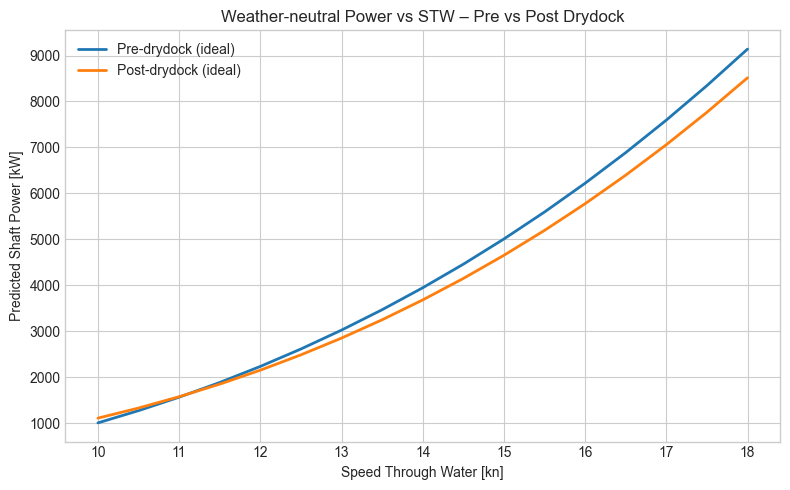

In [46]:
# 6.5: Plot weather-neutral curves

plt.figure(figsize=(8, 5))
plt.plot(speed_grid, P_pre_ideal,  lw=2, color="tab:blue",   label="Pre-drydock (ideal)")
plt.plot(speed_grid, P_post_ideal, lw=2, color="tab:orange", label="Post-drydock (ideal)")
plt.xlabel("Speed Through Water [kn]")
plt.ylabel("Predicted Shaft Power [kW]")
plt.title("Weather-neutral Power vs STW – Pre vs Post Drydock")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# CELL 7: Bootstrap to get uncertainty bands for pre and post curves

from sklearn.utils import resample

B = 100  # number of bootstrap models (kan justeres)

P_pre_boot = []
P_post_boot = []

X_pre = pre_ml[features].values
y_pre = pre_ml[TARGET_COL].values

X_post = post_ml[features].values
y_post = post_ml[TARGET_COL].values

for b in range(B):
    # --- Pre-drydock bootstrap sample ---
    X_pre_b, y_pre_b = resample(X_pre, y_pre, replace=True, random_state=42 + b)
    pre_model_b = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LinearRegression())
    ])
    pre_model_b.fit(X_pre_b, y_pre_b)
    P_pre_boot.append(pre_model_b.predict(X_baseline))

    # --- Post-drydock bootstrap sample ---
    X_post_b, y_post_b = resample(X_post, y_post, replace=True, random_state=4242 + b)
    post_model_b = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LinearRegression())
    ])
    post_model_b.fit(X_post_b, y_post_b)
    P_post_boot.append(post_model_b.predict(X_baseline))

P_pre_boot = np.vstack(P_pre_boot)   # shape (B, len(speed_grid))
P_post_boot = np.vstack(P_post_boot)

# Compute percentile bands (e.g. 5–95 %)
lower_q = 5
upper_q = 95

P_pre_low  = np.percentile(P_pre_boot,  lower_q, axis=0)
P_pre_high = np.percentile(P_pre_boot, upper_q, axis=0)

P_post_low  = np.percentile(P_post_boot,  lower_q, axis=0)
P_post_high = np.percentile(P_post_boot, upper_q, axis=0)


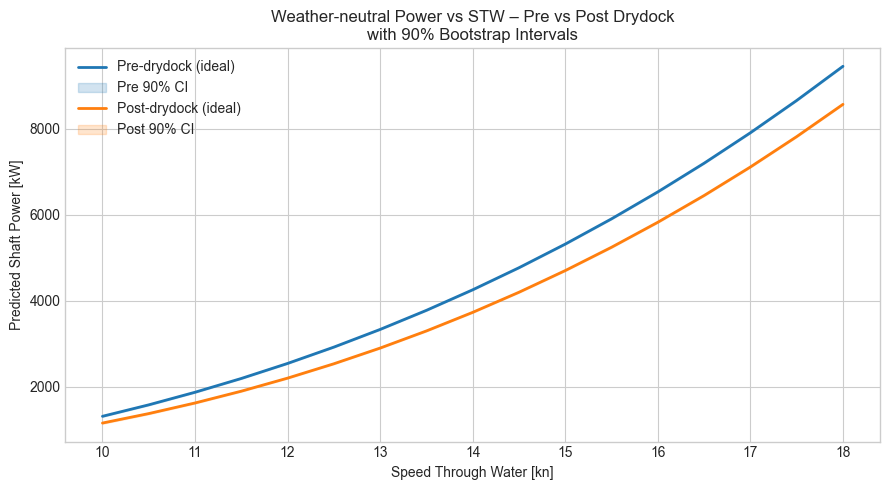

In [ ]:
# CELL 8: Plot weather-neutral curves with shaded uncertainty bands

plt.figure(figsize=(9, 5))

# Pre curve + band
plt.plot(speed_grid, P_pre_ideal,  lw=2, color="tab:blue", label="Pre-drydock (ideal)")
plt.fill_between(
    speed_grid, P_pre_low, P_pre_high,
    color="tab:blue", alpha=0.2, label="Pre 90% CI"
)

# Post curve + band
plt.plot(speed_grid, P_post_ideal, lw=2, color="tab:orange", label="Post-drydock (ideal)")
plt.fill_between(
    speed_grid, P_post_low, P_post_high,
    color="tab:orange", alpha=0.2, label="Post 90% CI"
)

plt.xlabel("Speed Through Water [kn]")
plt.ylabel("Predicted Shaft Power [kW]")
plt.title("Weather-neutral Power vs STW – Pre vs Post Drydock\nwith 90% Bootstrap Intervals")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:

# CELL 10: Table for speeds 12–18 knots

# Select only the rows where speed is between 12 and 18
mask_12_18 = (speed_grid >= 12) & (speed_grid <= 18)

table_df = pd.DataFrame({
    "speed_kn": speed_grid[mask_12_18],
    "P_pre_ideal_kW": P_pre_ideal[mask_12_18],
    "P_post_ideal_kW": P_post_ideal[mask_12_18],
    "efficiency_gain_pct": eff_gain_pct[mask_12_18],
})

# Format nicely
table_df = table_df.round({
    "P_pre_ideal_kW": 1,
    "P_post_ideal_kW": 1,
    "efficiency_gain_pct": 2
})

table_df


,speed_kn,P_pre_ideal_kW,P_post_ideal_kW,efficiency_gain_pct
0,12.0,2544.7,2203.5,13.41
1,12.5,2924.1,2536.9,13.24
2,13.0,3334.8,2901.9,12.98
3,13.5,3778.2,3299.6,12.67
4,14.0,4255.6,3731.5,12.32
5,14.5,4768.2,4198.6,11.95
6,15.0,5317.3,4702.3,11.57
7,15.5,5904.0,5243.9,11.18
8,16.0,6529.7,5824.5,10.80
9,16.5,7195.7,6445.5,10.43


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("seaborn-v0_8-whitegrid")

# Velg hvilken powerkolonne du bruker som target
target_series = TARGET_COL  # "ShaftPower_kW_smooth" eller "ShaftPower_kW"

# Pre-residualer (treningsdatasettet)
X_pre = pre_ml[features].values
y_pre = pre_ml[target_series].values
y_pre_hat = pre_model.predict(X_pre)
pre_residuals = y_pre - y_pre_hat

# Post-residualer
X_post = post_ml[features].values
y_post = post_ml[target_series].values
y_post_hat = post_model.predict(X_post)
post_residuals = y_post - y_post_hat

# Legg residualer inn i pre_ml/post_ml for plotting
pre_ml_plot = pre_ml.copy()
pre_ml_plot["residual"] = pre_residuals
pre_ml_plot["y_hat"] = y_pre_hat

post_ml_plot = post_ml.copy()
post_ml_plot["residual"] = post_residuals
post_ml_plot["y_hat"] = y_post_hat


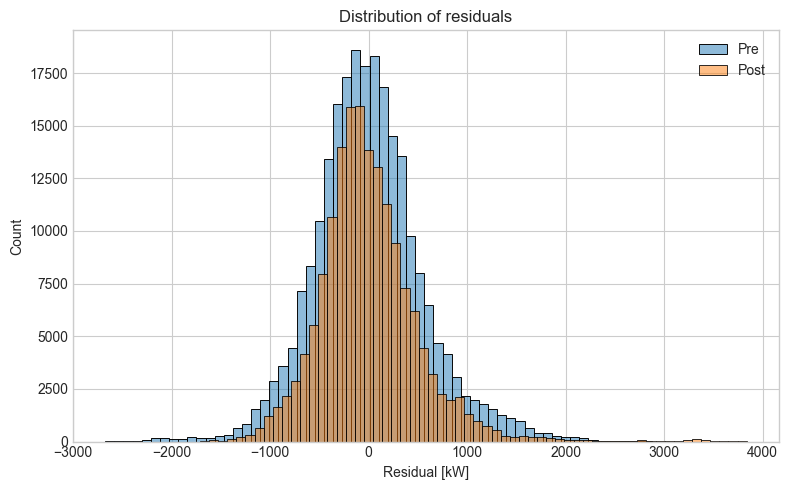

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(pre_residuals, bins=60, color="tab:blue", alpha=0.5, label="Pre")
sns.histplot(post_residuals, bins=60, color="tab:orange", alpha=0.5, label="Post")
plt.xlabel("Residual [kW]")
plt.ylabel("Count")
plt.title("Distribution of residuals")
plt.legend()
plt.tight_layout()
plt.show()


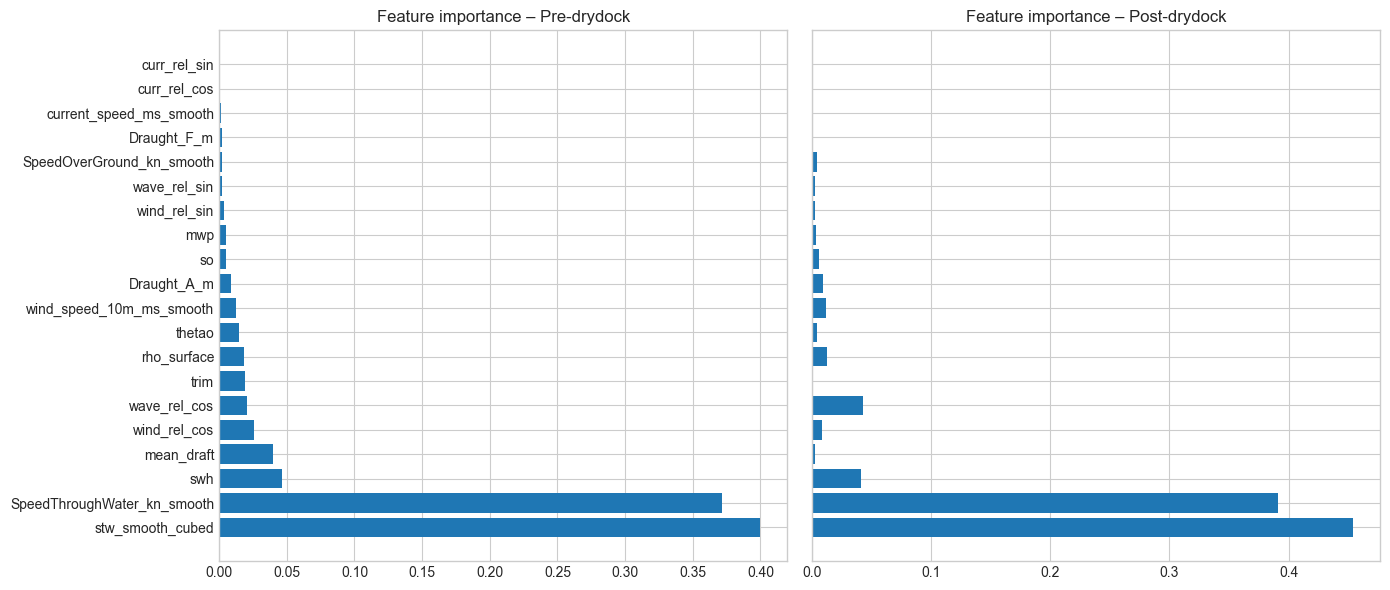

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Pre
rf_pre_imp = RandomForestRegressor(
    n_estimators=200, random_state=42, n_jobs=-1
)
rf_pre_imp.fit(X_pre, y_pre)
imp_pre = pd.DataFrame({
    "feature": features,
    "importance": rf_pre_imp.feature_importances_
}).sort_values("importance", ascending=False)

# Post
rf_post_imp = RandomForestRegressor(
    n_estimators=200, random_state=43, n_jobs=-1
)
rf_post_imp.fit(X_post, y_post)
imp_post = pd.DataFrame({
    "feature": features,
    "importance": rf_post_imp.feature_importances_
}).sort_values("importance", ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

axes[0].barh(imp_pre["feature"], imp_pre["importance"])
axes[0].invert_yaxis()
axes[0].set_title("Feature importance – Pre-drydock")

axes[1].barh(imp_post["feature"], imp_post["importance"])
axes[1].invert_yaxis()
axes[1].set_title("Feature importance – Post-drydock")

plt.tight_layout()
plt.show()
